The purpose of this notebook is to demonstrate a reproducible workflow for selecting AoIs in the LDM experiment.

In [1]:
%load_ext autoreload
%autoreload

In [1]:
import sys
import os

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as matplotlib
from matplotlib.colors import ListedColormap
import seaborn as sns
import scipy.io as io
import pandas as pd
from pandas import DataFrame, read_csv
from nivlink import Screen, Raw, align_to_aoi, compute_fixations, plot_heatmaps
import cv2
import readline
from math import dist
from scipy.spatial.distance import squareform, pdist

import warnings
from scipy.stats import kde
import nivlink
import ipywidgets as wdg
from scipy.stats import iqr
print('Powered by NivLink' + str(nivlink.__version__))

Powered by NivLink0.2.5


## 1. Labeling 

### Define screen parameters and add AoIs

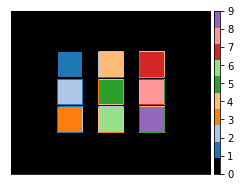

In [3]:
# Set screen metadata.
xdim, ydim, n_screens = 1280, 1024, 1 

# Initialize screen object.
info = Screen(xdim, ydim, n_screens)

# Recompute stimulus positions and spacing.
stim_size = 162
xcenter = np.floor(xdim/2); ycenter = np.floor(ydim/2);
dd = np.floor(stim_size/2);
xpos = [xcenter-3*dd-100, xcenter-dd, xcenter+100+dd];
ypos = [ycenter-3*dd-10, ycenter-dd, ycenter+dd+10];
xwidth = ywidth = stim_size
xpad = 0
ypad = 0

# Define and add areas of interest.
n_aois = 9
aois = np.empty((n_aois,2,2))

# Left column
aois[0] = np.matrix([[xpos[0]-xpad, ypos[0]-ypad], [xpos[0]+xwidth+xpad, ypos[0]+ywidth+ypad]])
aois[1] = np.matrix([[xpos[0]-xpad, ypos[1]-ypad], [xpos[0]+xwidth+xpad, ypos[1]+ywidth+ypad]])
aois[2] = np.matrix([[xpos[0]-xpad, ypos[2]-ypad], [xpos[0]+xwidth+xpad, ypos[2]+ywidth+ypad]])

# Middle column
aois[3] = np.matrix([[xpos[1]-xpad, ypos[0]-ypad], [xpos[1]+xwidth+xpad, ypos[0]+ywidth+ypad]])
aois[4] = np.matrix([[xpos[1]-xpad, ypos[1]-ypad], [xpos[1]+xwidth+xpad, ypos[1]+ywidth+ypad]])
aois[5] = np.matrix([[xpos[1]-xpad, ypos[2]-ypad], [xpos[1]+xwidth+xpad, ypos[2]+ywidth+ypad]])

# Right column
aois[6] = np.matrix([[xpos[2]-xpad, ypos[0]-ypad], [xpos[2]+xwidth+xpad, ypos[0]+ywidth+ypad]])
aois[7] = np.matrix([[xpos[2]-xpad, ypos[1]-ypad], [xpos[2]+xwidth+xpad, ypos[1]+ywidth+ypad]])
aois[8] = np.matrix([[xpos[2]-xpad, ypos[2]-ypad], [xpos[2]+xwidth+xpad, ypos[2]+ywidth+ypad]])

for a in range(0, n_aois):
    info.add_rectangle_aoi(aois[a,0,0], aois[a,1,0], aois[a,0,1], aois[a,1,1])
    
info.plot_aoi(0);

### Plot raw data for each subject.

In [11]:
all_subjects =  [23, 26, 27, 28, 29, 30, 31, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 49, 53, 54, 
                 55, 57, 58, 60, 61, 62, 63, 66, 67, 68, 69, 70, 71];

print('Found ' + str(len(all_subjects)) + ' subjects.')

Found 38 subjects.


In [12]:
def load_subj_data(subj_id):
    
    et_data_dir = os.getcwd().strip('ldm-analysis') + 'RawData/'# this expects RawData to be one directory up from the analysis repo
    edf_path = et_data_dir + 'Sub' + str(subj_id) + 'ET.edf'
    # Read subject's data from edf file.
    data = Raw(edf_path)
    # Filter out only eye position.
    raw_pos_data = data.data[:,0,(0,1)]
    # Grab messages for epoching step.
    messages = data.messages 
 
    return raw_pos_data, messages

In [25]:
def get_run_onsets(messages): 
    """ Returns run onsets. 
        
        This function is specific to how the experiment code handles
        messages to the EDF file during the task.

    Parameters
    ----------
    messages: array, shape (n_times, 1) 
        Array containing messages from the NivLink Raw object.

    Returns
    -------
    run_onsets : array, shape (n_runs, 2)
        Run IDs and start indices.

    """

    n_messages = len(messages)
    print('Found ' + str(n_messages) + ' messages...')
    run_onsets = np.empty((0,3), dtype = int)

    for m in np.arange(n_messages):
        
        this_message_index = messages[m][0]
        this_message = messages[m][1]
        
        ## We encountered a new run.
        if 'Run' in this_message:
             
            ## Get index of first XDAT 2 in this run. 
            ## This is specific to the LDM dataset
            ## because the first stim onset is not align with the Start Run message.   
            first_xdat2_message_index = messages[m+12][0]
            first_xdat2_message = messages[m+12][1]
            
            ## Initialize onset array for this run.
            this_run_onsets = np.empty((1,3), dtype = int); 
            
            this_run_onsets[:,0] = int(this_message.strip('Run '))
            # this_run_onsets[:,1] = int(this_message_index) # actual run start message
            this_run_onsets[:,1] = int(first_xdat2_message_index)  # first XDAT2 in run
              
        ## Re-construct End Run message index by looking at the last trial in each run.
        ## Assumes we consistently had 40 trial per run as per LDM_Run4.m
        if 'Trial 40' in this_message:
            
            last_xdat1_message_index = messages[m+6][0]
            last_xdat1_message = messages[m+6][1]
            
            this_run_onsets[:,2] = int(last_xdat1_message_index)
            run_onsets = np.vstack((run_onsets,this_run_onsets))
            
    return run_onsets

In [26]:
def mark_blocks(raw_pos_data, messages):

    ## Divide into runs for blockwise AoI customization.
    run_onsets = get_run_onsets(messages)
    n_runs, d = run_onsets.shape

    ## Make block index indicator.
    block_idx = np.zeros(len(raw_pos_data))
    for r in np.arange(n_runs):    
        block_start = run_onsets[r,1]
        block_end = run_onsets[r,2]    
        block_idx[block_start-1:block_end-1] = r+1

    ## Store in dataframe. 
    gaze_data = pd.DataFrame(data=raw_pos_data)
    gaze_data.columns = ['x','y'] 
    gaze_data['Block'] = block_idx.astype(int)

    return gaze_data

In [27]:
## Initialize colormap.
# Collect hex values from standard colormap.
cmap = cm.get_cmap('tab20', 20)

colors = []
for i in range(cmap.N):
    rgb = cmap(i)[:3] # will return rgba, we take only first 3 so we get rgb
    colors.append(matplotlib.colors.rgb2hex(rgb))

colors = colors[:9]

# Add black.
colors = np.insert(colors, 0, 'k')

# Construct new colormap.
cmap = ListedColormap(colors)

subject: 23
Found 3493 messages...
block: 1
block: 2
block: 3
block: 4
block: 5
block: 6
block: 7
block: 8
block: 9
block: 10


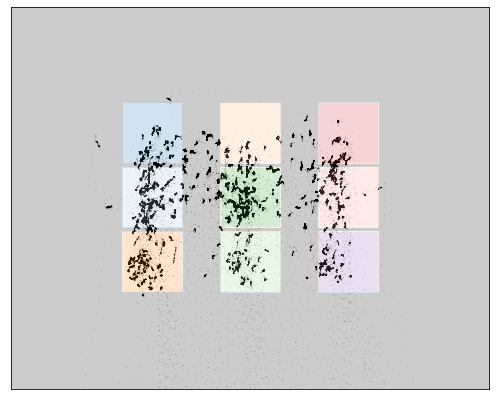

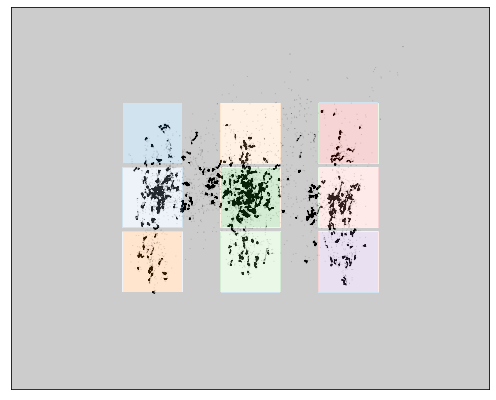

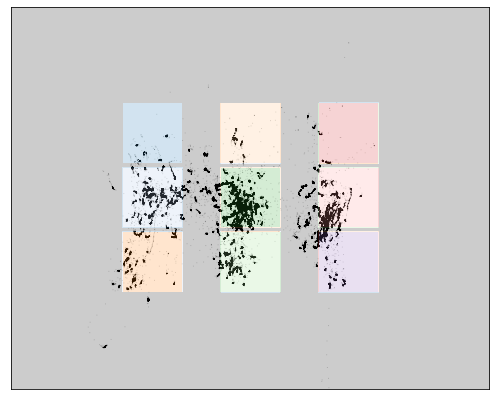

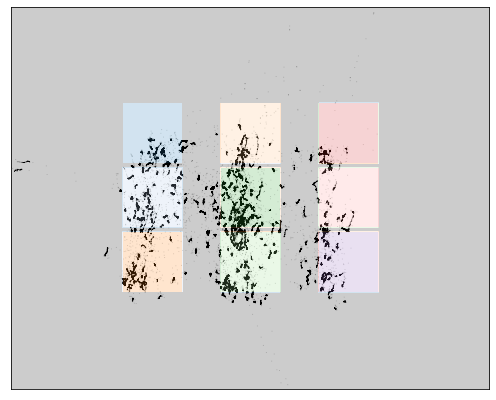

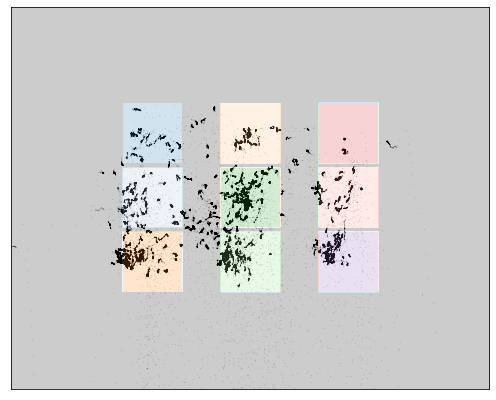

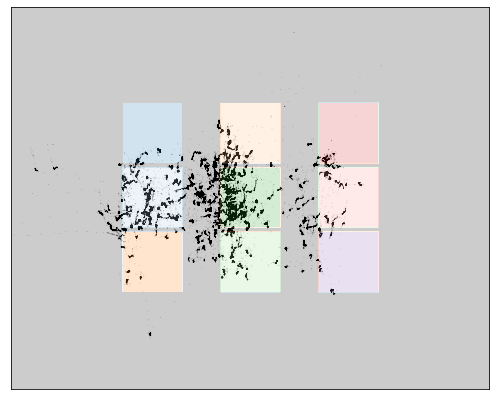

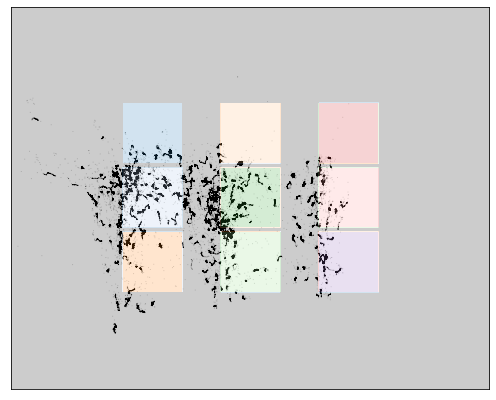

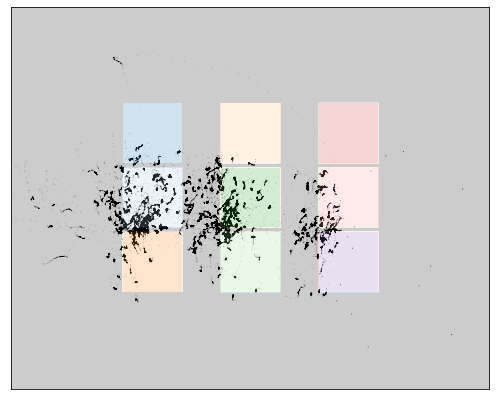

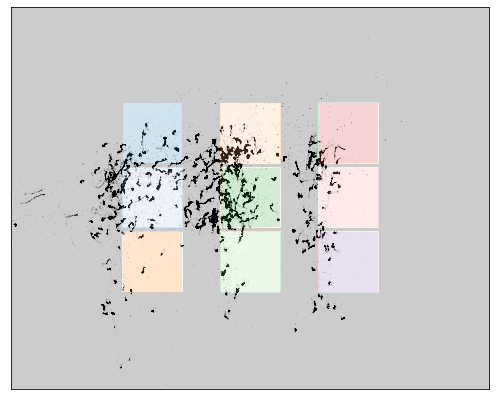

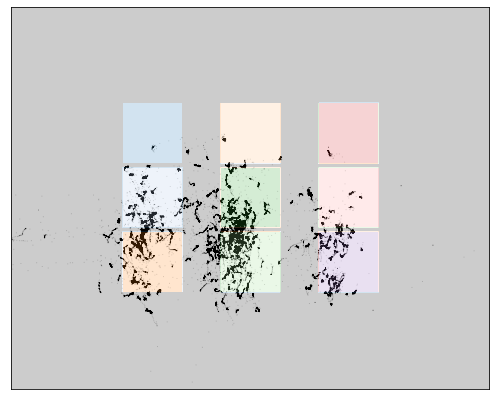

In [28]:
## Subject loop.

# Plot by block?
by_block = 1
my_dpi = 192 # correct for monitor in Meyer

# for subj_id in all_subjects:
for subj_id in [all_subjects[0]]:
    
    print('subject: ' + str(subj_id))
    
    raw_pos_data, messages = load_subj_data(subj_id)   
    gaze_data = mark_blocks(raw_pos_data, messages)
    
    if by_block: 

        for b in np.arange(10):

            block = b + 1
            print('block: ' + str(block))

            block_data = gaze_data.loc[gaze_data['Block'] == block][['x','y']].values
        
            ## Set some figure prelims.
            contrast = [0,0.5]

            ## Remove NaNs.
            mask = ~np.any(np.isnan(block_data),axis=1)
            x = block_data[mask,0]
            y = block_data[mask,1]
            x_y = np.column_stack([x,y])

            ## Compute 2D histogram in pixel space. 
            xedges = np.arange(0,info.xdim+1)
            yedges = np.arange(0,info.ydim+1)
            H, xedges, yedges = np.histogram2d(x, y,bins=(xedges, yedges))
            H = H.T

            ## Plot heatmap of blockwise raw eye-position with overlaid base AoIs.
            # Here, -3 and +8 correct for how tight layout works (not possible to save figure that exactly covers the size of the axes)
            fig, ax = plt.subplots(1,1,figsize=((1280-3)/my_dpi,(1024+8)/my_dpi));
            ax.imshow(H, interpolation='bilinear', cmap=cm.Greys, clim=(contrast[0], contrast[1]));
            ax.imshow(info.indices[:,:,0].T, alpha = 0.2, cmap = cmap)
            ax.set_xticks([]) 
            ax.set_yticks([])
            fig.tight_layout(pad=0)
            plt.savefig('labelcenters/Sub' + str(subj_id) + '_block_' + str(block) + '.png', format='png', dpi=my_dpi)
            
    else: 
        
        block_data = gaze_data.loc[gaze_data['Block'].isin(np.arange(10)+1)][['x','y']].values

        ## Set some figure prelims.
        contrast = [0,0.5]

        ## Remove NaNs.
        mask = ~np.any(np.isnan(block_data),axis=1)
        x = block_data[mask,0]
        y = block_data[mask,1]
        x_y = np.column_stack([x,y])

        ## Compute 2D histogram in pixel space. 
        xedges = np.arange(0,info.xdim+1)
        yedges = np.arange(0,info.ydim+1)
        H, xedges, yedges = np.histogram2d(x, y,bins=(xedges, yedges))
        H = H.T
        
        ## Plot heatmap of blockwise raw eye-position with overlaid base AoIs.
        # Here, -3 and +8 correct for how tight layout works (not possible to save figure that exactly covers the size of the axes)
        fig, ax = plt.subplots(1,1,figsize=((1280-3)/my_dpi,(1024+8)/my_dpi));
        # fig.set_size_pixels(1280,1024)
        ax.imshow(H, interpolation='bilinear', cmap=cm.Greys, clim=(contrast[0], contrast[1]));
        ax.imshow(info.indices[:,:,0].T, alpha = 0.1, cmap = cmap)
        ax.set_xticks([]) 
        ax.set_yticks([])
        fig.tight_layout(pad=0)
        plt.savefig('labelcenters/Sub' + str(subj_id) + '.png', format='png', dpi=my_dpi)


### Label centers

This is done blockwise separately by two individual raters by running **labelcenters/labelcenters.py** from the command line.

In [3]:
aoisidelength = 162
aoispacelength = 1
show_image = 1
target_directory = "labelcenters/"

## 2. Averaging

In [4]:
# function that reads in two csvs with top-left corners and averages out the centers
# outputs a pandas df with all the averaged centers
def averageCenters(input_a, input_b):
    df_a = pd.read_csv(input_a)
    df_b = pd.read_csv(input_b)
    df_average = df_a
    for (clickname, point) in df_a.iteritems():
        df_average[clickname] = calculateMidpoint(df_a[clickname], df_b[clickname])
    return df_average  

# calculates midpoint between two top-left corners: x = (x1 + x2) / 2, y = (y1 + y2) / 2
# returns integer value of coordinates of center of roi
def calculateMidpoint(point1, point2):
    x = (point1[0] + point2[0])//2
    y = (point1[1] + point2[1])//2
    return [(x+(aoisidelength//2)),(y+(aoisidelength//2))] # FIX AFTER DONE

def plotCenters(img, df):
    for (clickname, point) in df.iteritems():
        x = point[0]
        y = point[1]
        # draw a circle over the center of the radius
        cv2.circle(img, (x,y), radius=5, color=(0, 0, 255), thickness=-1)

        # draw a rectangle the size of the ROI
        cv2.rectangle(img, ((x-(aoisidelength//2)),(y-(aoisidelength//2))), 
                        ((x+(aoisidelength//2)),(y+(aoisidelength//2))), 
                        color=(0, 0, 255), thickness=1)

In [5]:
def doAverage(input_image, show_image):
    # reading the image
    img = cv2.imread(input_image, 1)

    input_name = input_image.split(".")[0]

    # note: these inputs are currently top left corners, not centers
    # this is for averaging two raters, change initials for future use.
    input_b = input_name + "_centers_NB.csv"
    input_a = input_name + "_centers_AR.csv"
    
    df = averageCenters(input_a, input_b)
    
    plotCenters(img, df)

    # show image if desired
    if int(show_image) == 0:
        # displaying the image with average rois overlayed
        cv2.imshow('image', img)
        cv2.waitKey(0)

    # saving the dataframe 
    output_filename = input_name + "_average_centers"
    df.to_csv(output_filename + '.csv', index=False) 

    # save the image
    cv2.imwrite(output_filename + '.png', img)

    return df

### Check for overlap

In [6]:
def checkOverlap(df):
    for clickx in df:
        for clicky in df:
            if clickx != clicky:
                distance = dist((df[clickx][0], df[clickx][1]), (df[clicky][0], df[clicky][1]))
                if distance < aoisidelength:
                    return True
    return False

### Fix overlap

In [7]:
def findAngle(p1, p2):
    ang1 = np.arctan2(*p1[::-1])
    ang2 = np.arctan2(*p2[::-1])
    return np.rad2deg((ang1 - ang2) % (2 * np.pi))

def fixOverlap(df):
    df_new = df
    # print(df_new)
    for clickx in df:
        for clicky in df:
            if clickx != clicky:
                distance = dist((df[clickx][0], df[clickx][1]), (df[clicky][0], df[clicky][1]))
                angle = findAngle((df[clickx][0], df[clickx][1]), (df[clicky][0], df[clicky][1]))
                if distance < aoisidelength and angle < 180:
                    # print("clickx: " + clickx + " and clicky: " + clicky + " ")
                    # print("angle: " + str(angle))
                    x_distance = df[clickx][0] - df[clicky][0]
                    # print("X: " + str(x_distance))
                    y_distance = df[clickx][1] - df[clicky][1]
                    # print("Y: " + str(y_distance))
                    # horizontal overlap
                    if abs(x_distance) < aoisidelength and abs(x_distance) > 20:
                        # print("X Overlap")
                        # clickx is left of clicky
                        if x_distance < 0:
                            if clickx in ['click0', 'click1', 'click2']:
                                df_new[clickx][0] = df[clickx][0] - abs(aoisidelength - x_distance)
                            elif clicky in ['click6', 'click7', 'click8']:
                                df_new[clicky][0] = df[clicky][0] + abs(aoisidelength - x_distance)
                        # clicky is left of clickx
                        else:
                            if clicky in ['click0', 'click1', 'click2']:
                                df_new[clicky][0] = df[clicky][0] - abs(aoisidelength - abs(x_distance))
                            elif clickx in ['click6', 'click7', 'click8']:
                                df_new[clickx][0] = df[clickx][0] + abs(aoisidelength - abs(x_distance))
                    if abs(y_distance) < aoisidelength and abs(y_distance) > 20:
                        # print("Y Overlap")
                        # clickx is above clicky
                        if y_distance < 0:
                            if clickx in ['click0', 'click3', 'click6']:
                                df_new[clickx][1] = df[clickx][1] - abs(aoisidelength - y_distance)
                            elif clicky in ['click2', 'click5', 'click8']:
                                df_new[clicky][1] = df[clicky][1] + abs(aoisidelength - y_distance)
                        # clicky is above clickx
                        else:
                            if clicky in ['click0', 'click3', 'click6']:
                                df_new[clicky][1] = df[clicky][1] - abs(aoisidelength - abs(y_distance))
                            elif clickx in ['click2', 'click5', 'click8']:
                                df_new[clickx][1] = df[clickx][1] + abs(aoisidelength - abs(y_distance))
    return df_new

### Main Function to Average Centers, Check Overlap, and Fix Overlap

In [11]:
# iterate through original image files that we saved out above
for filename in os.listdir(target_directory):
        # select original image files (consider moving these to separate folder)
        if filename.endswith(".png") and ("labeled" not in filename) and ("centers" not in filename):
            filename = target_directory + filename
            print(filename)
            input_name = filename.split(".")[0]
            # do not show original averaged images, so always 1
            df = doAverage(filename, 1)
            overlapExists = checkOverlap(df)
            if overlapExists:
                df_final = fixOverlap(df)
                output_filename =  input_name + "_average_centers_fixed"
                df_final.to_csv(output_filename + '.csv', index=False)
            else:
                df_final = df

            #### saving image with rois and csvs with centers ###

            # reading the image
            img = cv2.imread(filename, 1)

            # plot the average centers on the image
            plotCenters(img, df_final)

            # show images if desired
            if int(show_image) == 0:
                # displaying the image with average rois overlayed
                cv2.imshow('image', img)
                img2 = img[:,:,::-1]
                plt.imshow(img2)
                cv2.waitKey(0)

            # saving the final dataframe 
            output_filename = input_name + "_average_centers_final"
            df_final.to_csv(output_filename + '.csv', index=False) 

            # save the final image
            cv2.imwrite(output_filename + '.png', img)

labelcenters/Sub43_block_7.png
labelcenters/Sub61_block_1.png
labelcenters/Sub26_block_5.png
labelcenters/Sub29.png
labelcenters/Sub33_block_7.png
labelcenters/Sub68_block_2.png
labelcenters/Sub40_block_10.png
labelcenters/Sub36_block_2.png
labelcenters/Sub71_block_6.png
labelcenters/Sub63_block_8.png
labelcenters/Sub47_block_10.png
labelcenters/Sub46_block_2.png
labelcenters/Sub46_block_3.png
labelcenters/Sub63_block_9.png
labelcenters/Sub23_block_1.png
labelcenters/Sub71_block_7.png
labelcenters/Sub36_block_3.png
labelcenters/Sub53_block_1.png
labelcenters/Sub33_block_6.png
labelcenters/Sub68_block_3.png
labelcenters/Sub28.png
labelcenters/Sub26_block_4.png
labelcenters/Sub55_block_10.png
labelcenters/Sub43_block_6.png
labelcenters/Sub43_block_4.png
labelcenters/Sub58_block_9.png
labelcenters/Sub44_block_8.png
labelcenters/Sub26_block_6.png
labelcenters/Sub61_block_2.png
labelcenters/Sub68_block_1.png
labelcenters/Sub33_block_4.png
labelcenters/Sub28_block_9.png
labelcenters/Sub34_bl

## 3. Reformatting into single dataframe

In [23]:
# instantiate empty dataframe with columns as proper column names
column_names = ['aoi0_x', 'aoi0_y', 'aoi1_x', 'aoi1_y', 'aoi2_x', 'aoi2_y', 'aoi3_x', 'aoi3_y', 'aoi4_x', 'aoi4_y', 'aoi5_x', 'aoi5_y', 'aoi6_x', 'aoi6_y', 'aoi7_x', 'aoi7_y', 'aoi8_x', 'aoi8_y']
df = pd.DataFrame(columns=column_names)

# read in each row by iterating through images
for filename in os.listdir(target_directory):
        # select original image files (consider moving these to separate folder)
        if filename.endswith(".png") and ("labeled" not in filename) and ("centers" not in filename):
            input_name = filename.split(".")[0]
            print(input_name)
            centers = pd.read_csv(target_directory + input_name + "_average_centers_final.csv")
            centers['index'] = ['x', 'y']
            centers = centers.set_index('index')
            new_row = []
            for row, col in centers.iteritems():
                new_row = new_row + [col.x, col.y]
            df.loc[input_name] = new_row

Sub43_block_7
[329, 362, 332, 525, 330, 692, 557, 361, 564, 525, 565, 689, 826, 373, 832, 538, 832, 703]
       click0  click1  click2  click3  click4  click5  click6  click7  click8
index                                                                        
x         329     332     330     557     564     565     826     832     832
y         362     525     692     361     525     689     373     538     703
Sub61_block_1
[353, 347, 357, 511, 353, 678, 549, 350, 556, 517, 563, 681, 810, 341, 818, 505, 827, 672]
       click0  click1  click2  click3  click4  click5  click6  click7  click8
index                                                                        
x         353     357     353     549     556     563     810     818     827
y         347     511     678     350     517     681     341     505     672
Sub26_block_5
[360, 372, 367, 541, 363, 708, 586, 375, 587, 546, 593, 710, 819, 377, 824, 545, 828, 713]
       click0  click1  click2  click3  click4  click5  click6

In [25]:
df.to_csv('allCenters.csv') 